In [1]:
import numpy as np
import cv2
from pyproj import Transformer
from my_vbr_utils.vbr_dataset import VBRDataset, load_scene_calibration
from my_vbr_utils.utilities import load_scene_correspondences

# --- Config and Dataset Loading ---
# Set these variables to configure your scene and utility path
scene_name = 'spagna_train0'
vbr_utils_root = '/home/bjangley/VPR/mast3r-v2/my_vbr_utils'

config_path = f'{vbr_utils_root}/vbrPaths.yaml'
correspondence_json = f"{vbr_utils_root}/GPSalignment/{scene_name}.json"

# Load dataset and calibration
all_loaded = VBRDataset(config_path, locations=['spagna'])
vbr_scene = all_loaded.get_combined_dataset()
calib = load_scene_calibration(scene_name, config_path)

# Load correspondences
data = load_scene_correspondences(correspondence_json)
image_indices = data['image_indices']
pixel_locations = data['pixel_locations']
locations = data['locations']
gps = data['gps']




Loading scene: spagna_train0
  KITTI path: /datasets/vbr_slam/spagna/spagna_train0_kitti
  GT path: /datasets/vbr_slam/spagna/spagna_train0/spagna_train0_gt.txt
  ✓ Successfully loaded spagna_train0
Loaded 1 training scenes: ['spagna_train0']


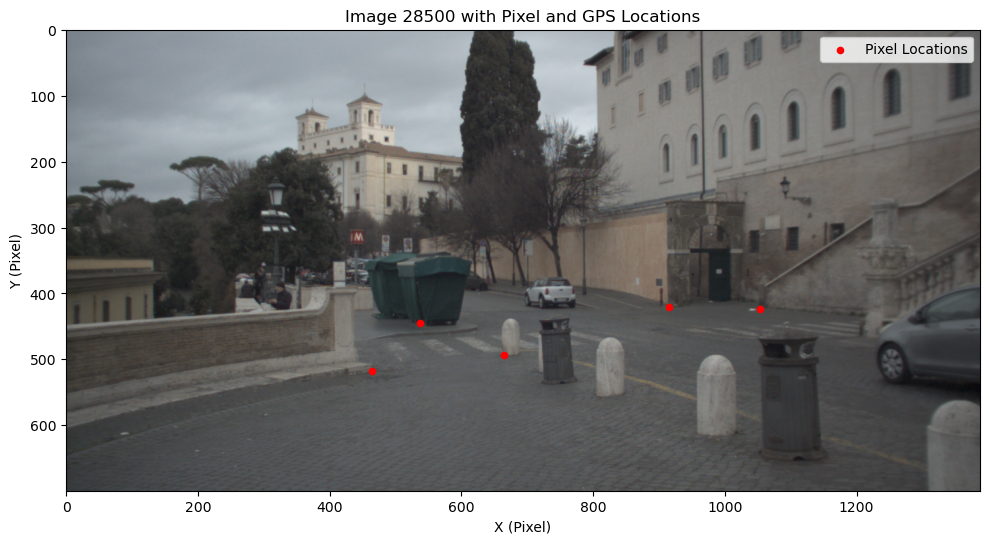

In [2]:
import matplotlib.pyplot as plt
from PIL import Image
# Load the image corresponding to the first index
idx = 2
image_idx = image_indices[idx]
image = Image.open(vbr_scene[image_idx]['image'])
pixels = np.array(pixel_locations[idx])
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(image)
ax.scatter(pixels[:, 0], pixels[:, 1], c='red', s=20, label='Pixel Locations')
ax.set_title(f"Image {image_idx} with Pixel and GPS Locations")
ax.set_xlabel("X (Pixel)")
ax.set_ylabel("Y (Pixel)")
ax.legend()
plt.tight_layout()
plt.show()

In [3]:
import numpy as np
import cv2
from pyproj import CRS, Transformer
from pyproj.database import query_utm_crs_info
from pyproj.aoi import AreaOfInterest
from my_utils.transformations import pose_to_se3
def localize_and_align_trajectory(
    scene_name,
    vbr_dataset,
    calib,
    correspondence_json,
    verbose=True
):
    """
    Localize camera trajectory using correspondences and align local trajectory to global GPS.

    Parameters:
    -----------
    scene_name : str
        Name of the scene (used for calibration).
    vbr_dataset : VBRDataset
        Loaded VBR dataset object.
    calib : dict
        Camera calibration dictionary for the scene.
    correspondence_json : dict
        Dictionary loaded from correspondences JSON.
    verbose : bool
        If True, prints progress and intermediate results.

    Returns:
    --------
    dict with keys:
        - 'aligned_latlon_traj': list of (lat, lon) tuples for aligned trajectory
        - 'scale': estimated similarity scale
        - 'rotation': estimated similarity rotation matrix
        - 'translation': estimated similarity translation vector
        - 'camera_positions': list of dicts with per-image localization results
    """
    # --- Extract data from JSON ---
    image_indices = correspondence_json['image_indices']
    pixel_locations = correspondence_json['pixel_locations']
    locations = correspondence_json['locations']
    gps = correspondence_json['gps']
    
    # --- Find UTM zone ---
    lat, lon = gps
    utm_crs_list = query_utm_crs_info(
        datum_name="WGS 84",
        area_of_interest=AreaOfInterest(
            west_lon_degree=lon, east_lon_degree=lon,
            south_lat_degree=lat, north_lat_degree=lat
        )
    )
    if not utm_crs_list:
        raise ValueError("Could not find UTM CRS for GPS coordinates.")
    
    utm_crs = CRS.from_epsg(utm_crs_list[0].code)
    wgs84_crs = CRS.from_epsg(4326)
    to_utm = Transformer.from_crs(wgs84_crs, utm_crs, always_xy=True)
    to_latlon = Transformer.from_crs(utm_crs, wgs84_crs, always_xy=True)

    # --- Camera Intrinsics ---
    K = calib['cam_l']['K'].astype(np.float32)
    dist = calib['cam_l']['dist_coeffs'].astype(np.float32)

    # --- Solve PnP for all images ---
    camera_positions = []
    for idx in range(len(image_indices)):
        pixels = np.array(pixel_locations[idx], dtype=np.float32)
        gps_coords = locations[idx]
        utm_coords = np.array([to_utm.transform(lon, lat) for lat, lon in gps_coords], dtype=np.float32)
        object_points = np.hstack([utm_coords, np.zeros((len(utm_coords), 1), dtype=np.float32)])

        success, rvec, tvec, inliers = cv2.solvePnPRansac(
            object_points, pixels, K, dist, flags=cv2.SOLVEPNP_ITERATIVE
        )
        if not success:
            if verbose:
                print(f"PnP failed for index {idx}")
            continue

        R, _ = cv2.Rodrigues(rvec)
        camera_pos_utm = -R.T @ tvec
        lon, lat = to_latlon.transform(camera_pos_utm[0].item(), camera_pos_utm[1].item())

        pose = vbr_dataset[image_indices[idx]]['pose']
        T_utm_local_i = None
        if not (pose == -1).all():
            T_cam_utm = np.eye(4)
            T_cam_utm[:3, :3] = R
            T_cam_utm[:3, 3] = tvec.reshape(-1)
            T_utm_cam = np.linalg.inv(T_cam_utm)
            T_local_cam = pose_to_se3(pose)
            T_local_cam_inv = np.linalg.inv(T_local_cam)
            T_utm_local_i = T_utm_cam @ T_local_cam_inv

        camera_positions.append({
            'image_index': image_indices[idx],
            'latlon': [lat, lon],
            'R': R,
            'tvec': tvec,
            'T_utm_local': T_utm_local_i
        })

        if verbose:
            print(f"   Image {image_indices[idx]} Estimated Camera Position:")
            print(f"   Latitude : {lat:.7f}, Longitude: {lon:.7f}")

    if not camera_positions:
        raise RuntimeError("No successful PnP localizations.")

    # --- Similarity Transform ---
    global_latlon = [cp['latlon'] for cp in camera_positions]
    local_pts = []
    global_pts = []
    for cp in camera_positions:
        local_xyz = vbr_dataset[cp['image_index']]['pose'][:2]
        local_pts.append(local_xyz)
        lat, lon = cp['latlon']
        utm = np.array(to_utm.transform(lon, lat))
        global_pts.append(utm)
    local_pts = np.vstack(local_pts)
    global_pts = np.vstack(global_pts)

    # Compute similarity
    def compute_similarity(source, target):
        src_mean = source.mean(axis=0)
        tgt_mean = target.mean(axis=0)
        src_c = source - src_mean
        tgt_c = target - tgt_mean
        scale = np.linalg.norm(tgt_c) / np.linalg.norm(src_c)
        H = src_c.T @ tgt_c
        U, _, Vt = np.linalg.svd(H)
        R = Vt.T @ U.T
        if np.linalg.det(R) < 0:
            Vt[-1, :] *= -1
            R = Vt.T @ U.T
        t = tgt_mean - scale * (R @ src_mean)
        return scale, R, t

    scale, rotation, translation = compute_similarity(local_pts, global_pts)

    # Apply to full trajectory
    local_traj_full = np.array(vbr_dataset.get_local_trajectory())
    aligned_utm = scale * (rotation @ local_traj_full[:, :2].T).T + translation
    xs, ys = aligned_utm[:, 0], aligned_utm[:, 1]
    lons, lats = to_latlon.transform(xs, ys)
    aligned_latlon_traj = list(zip(lats, lons))

    if verbose:
        print(f"\n Similarity Transform Parameters:")
        print(f"Scale: {scale:.6f}")
        print(f"Rotation:\n{rotation}")
        print(f"Translation: {translation}\n")

    return {
        'aligned_latlon_traj': aligned_latlon_traj,
        'scale': scale,
        'rotation': rotation,
        'translation': translation,
        'camera_positions': camera_positions
    }

# Load correspondences
data = load_scene_correspondences(correspondence_json)

# Localize and align
results = localize_and_align_trajectory(
    scene_name, vbr_scene, calib, data, verbose=True
)

# Access aligned trajectory
aligned_traj = results['aligned_latlon_traj']
R = results['rotation']
yaw = np.degrees(np.arctan2(R[1, 0], R[0, 0]))  # Extract yaw from similarity transform

   Image 1528 Estimated Camera Position:
   Latitude : 41.9060544, Longitude: 12.4822755
   Image 4295 Estimated Camera Position:
   Latitude : 41.9064430, Longitude: 12.4814490
   Image 28500 Estimated Camera Position:
   Latitude : 41.9062059, Longitude: 12.4831499
   Image 34155 Estimated Camera Position:
   Latitude : 41.9053546, Longitude: 12.4833598

 Similarity Transform Parameters:
Scale: 1.027170
Rotation:
[[ 0.73403702 -0.67910946]
 [ 0.67910946  0.73403702]]
Translation: [ 291152.73602001 4642449.62913981]



In [4]:
# %%time
# import time
from pyproj import CRS, Transformer
from pyproj.database import query_utm_crs_info
from pyproj.aoi import AreaOfInterest
from my_utils.transformations import pose_to_se3

lat, lon = gps  # Ensure gps = (lat, lon)

# Find the UTM CRS info for the given point
utm_crs_list = query_utm_crs_info(
    datum_name="WGS 84",
    area_of_interest=AreaOfInterest(
        west_lon_degree=lon,
        south_lat_degree=lat,
        east_lon_degree=lon,
        north_lat_degree=lat
    ),
)

if not utm_crs_list:
    raise ValueError("Could not find a UTM CRS for the given coordinates.")

utm_crs = CRS.from_epsg(utm_crs_list[0].code)
wgs84_crs = CRS.from_epsg(4326)
print(utm_crs)
to_utm = Transformer.from_crs(wgs84_crs, utm_crs, always_xy=True)
to_latlon = Transformer.from_crs(utm_crs, wgs84_crs, always_xy=True)

EPSG:32633


Local trajectory shape: (42435, 7)
X range: [-64.8, 84.0] meters
Y range: [-182.8, 38.7] meters


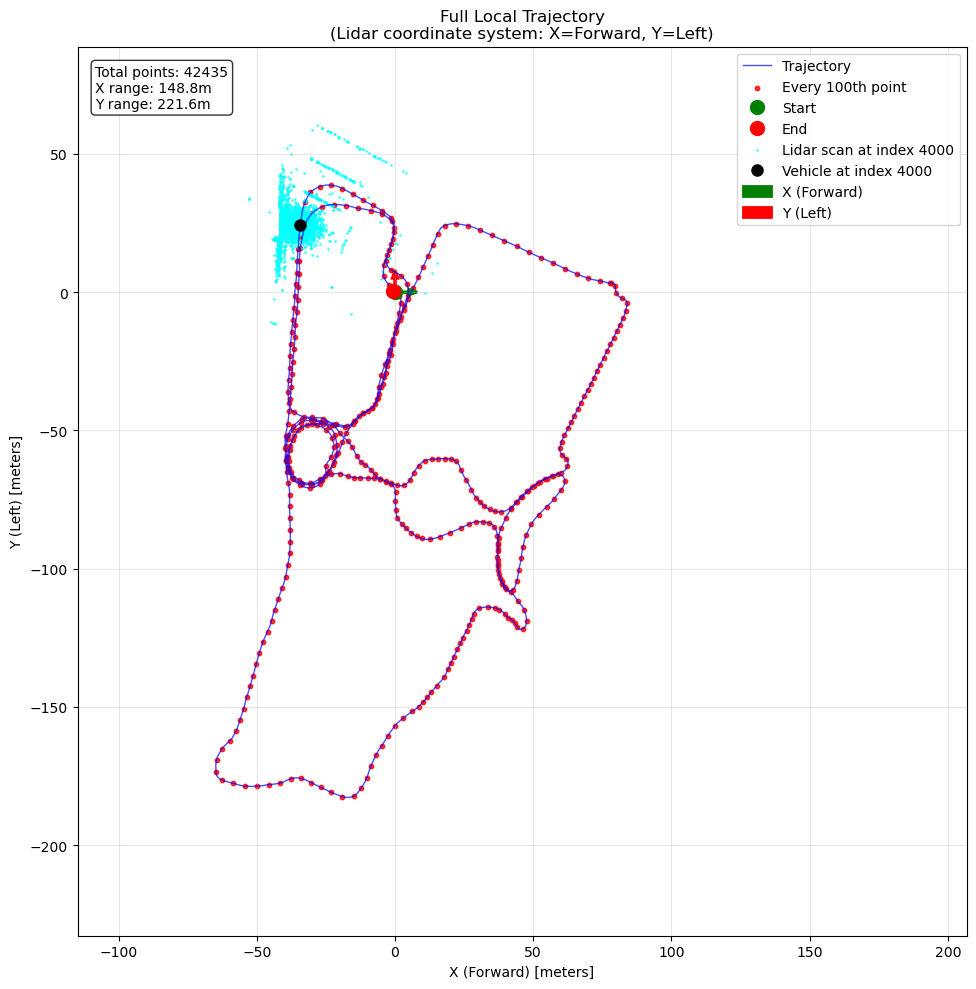

In [5]:
# Plot the full local trajectory (corrected for lidar frame)
import matplotlib.pyplot as plt
import numpy as np
from my_utils.transformations import pose_to_se3
local_traj_full = np.array(vbr_scene.get_local_trajectory())
print(f"Local trajectory shape: {local_traj_full.shape}")
print(f"X range: [{local_traj_full[:,0].min():.1f}, {local_traj_full[:,0].max():.1f}] meters")
print(f"Y range: [{local_traj_full[:,1].min():.1f}, {local_traj_full[:,1].max():.1f}] meters")
idx = 4000
max_points = 5000
# Get lidar data
lidar_xyz = vbr_scene.get_lidar(idx)
lidar_xy = lidar_xyz[:, :2]
pose = pose_to_se3(local_traj_full[idx,:])
# Assuming `pose` is a 4x4 transformation matrix (SE(3)) for the current index
lidar_xyz_hom = np.hstack([lidar_xyz, np.ones((lidar_xyz.shape[0], 1))])  # Convert to homogeneous coordinates
# Apply pose transformation
transformed_lidar = (pose @ lidar_xyz_hom.T).T  # Transform lidar points
transformed_lidar = transformed_lidar[:, :3]  # Convert back to Cartesian coordinates
# Subsample if too many points
if transformed_lidar.shape[0] > max_points:
        idxs = np.random.choice(transformed_lidar.shape[0], max_points, replace=False)
        transformed_lidar = transformed_lidar[idxs]

# Create the plot

fig, ax = plt.subplots(figsize=(10, 10))

# Plot the trajectory
ax.plot(local_traj_full[:,0], local_traj_full[:,1], 'b-', linewidth=1, alpha=0.7, label='Trajectory')
ax.scatter(local_traj_full[::100,0], local_traj_full[::100,1], c='red', s=10, alpha=0.8, label='Every 100th point')

# Mark start and end points
ax.plot(local_traj_full[0,0], local_traj_full[0,1], 'go', markersize=10, label='Start')
ax.plot(local_traj_full[-1,0], local_traj_full[-1,1], 'ro', markersize=10, label='End')

# Add the single lidar scan at the vehicle position
vehicle_x, vehicle_y = local_traj_full[idx, 0], local_traj_full[idx, 1]

# Transform lidar points to global coordinates (simple translation, no rotation for now)
global_lidar_x = transformed_lidar[:, 0] 
global_lidar_y = transformed_lidar[:, 1] 

# Plot lidar points
ax.scatter(global_lidar_x, global_lidar_y, c='cyan', s=1, alpha=0.6, label=f'Lidar scan at index {idx}')
# Mark the vehicle position for this lidar scan
ax.plot(vehicle_x, vehicle_y, 'ko', markersize=8, label=f'Vehicle at index {idx}')


# Add coordinate frame at origin (corrected for lidar frame)
origin_x, origin_y = local_traj_full[0,0], local_traj_full[0,1]
arrow_length = 5  # meters
ax.arrow(origin_x, origin_y, arrow_length, 0, head_width=2, head_length=3, fc='green', ec='green', linewidth=2, label='X (Forward)')
ax.arrow(origin_x, origin_y, 0, arrow_length, head_width=2, head_length=3, fc='red', ec='red', linewidth=2, label='Y (Left)')

# Set equal aspect ratio and formatting
ax.set_aspect('equal')
# Ensure x and y axes have the same scale
x_min, x_max = local_traj_full[:, 0].min(), local_traj_full[:, 0].max()
y_min, y_max = local_traj_full[:, 1].min(), local_traj_full[:, 1].max()
range_max = max(x_max - x_min, y_max - y_min)  # Find the larger range
ax.set_xlim(x_min-50, x_min + range_max+50)
ax.set_ylim(y_min-50, y_min + range_max+50)


ax.grid(True, alpha=0.3)
ax.set_xlabel('X (Forward) [meters]')  # Corrected label
ax.set_ylabel('Y (Left) [meters]')     # Corrected label
ax.set_title('Full Local Trajectory\n(Lidar coordinate system: X=Forward, Y=Left)')
ax.legend()

# Add statistics text box
stats_text = f"Total points: {len(local_traj_full)}\n"
stats_text += f"X range: {local_traj_full[:,0].max() - local_traj_full[:,0].min():.1f}m\n"
stats_text += f"Y range: {local_traj_full[:,1].max() - local_traj_full[:,1].min():.1f}m"
ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

In [6]:
def compute_compass_headings_utm(latlon_traj, to_utm, yaw, utm_to_compass_offset=90):
    """
    Compute compass heading using UTM coordinates for accurate metric differences.
    Adjusts UTM headings to align with compass directions using rotation matrices.
    """
    # Convert all latlon to UTM (X, Y in meters)
    utm_coords = np.array([to_utm.transform(lon, lat) for lat, lon in latlon_traj])
    xs = utm_coords[:, 0]
    ys = utm_coords[:, 1]
    n_points = len(xs)
    if n_points < 2:
        return np.array([0.0])  # Not enough points to compute headings

    # Compute trajectory direction (motion direction in UTM)
    dx = np.diff(xs)
    dy = np.diff(ys)
    utm_headings = np.zeros(n_points)
    utm_headings[0] = np.degrees(np.arctan2(dy[0], dx[0]))  # First point heading
    if n_points > 2:
        dx_central = xs[2:] - xs[:-2]
        dy_central = ys[2:] - ys[:-2]
        utm_headings[1:-1] = np.degrees(np.arctan2(dy_central, dx_central))  # Central difference
    utm_headings[-1] = np.degrees(np.arctan2(dy[-1], dx[-1]))  # Last point heading
    trajectory_headings = (90 - utm_headings) % 360
    return trajectory_headings
# Usage:

print(f"Yaw from similarity transform: {yaw:.2f}°")
compass_headings = compute_compass_headings_utm(aligned_traj, to_utm, yaw)
print(f"First few global headings: {compass_headings[:3]}")


Yaw from similarity transform: 42.77°
First few global headings: [164.12588721 164.12603135 181.29700768]


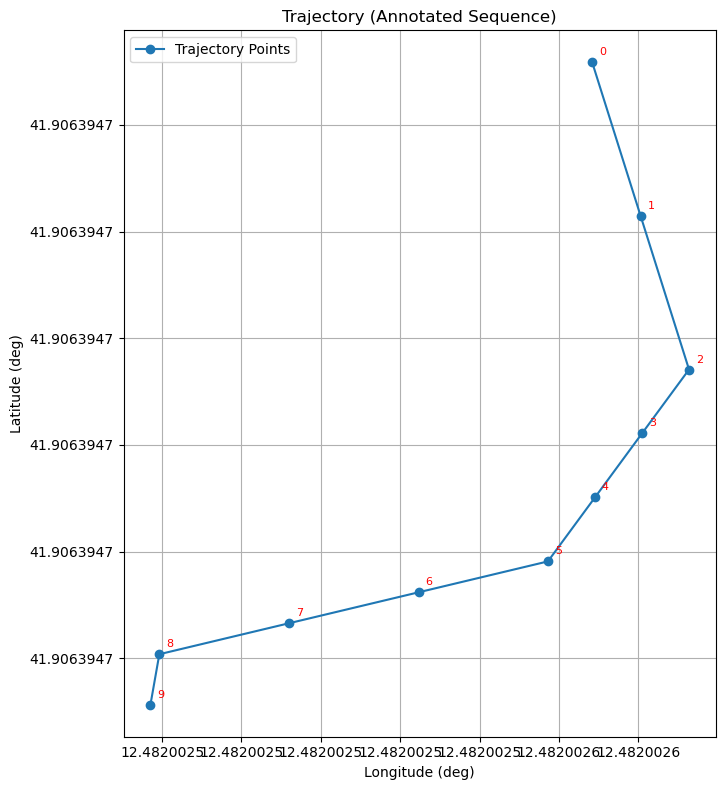

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FormatStrFormatter

latlon_arr = np.array(aligned_traj)
n = 0  # Starting index for points to plot
n1 = 10  # Ending index for points to plot
step=1
# Calculate aspect ratio correction for latitude
mean_lat = np.mean(latlon_arr[n:n1:step, 0])
aspect = 1.0 / np.cos(np.deg2rad(mean_lat))

fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(latlon_arr[n:n1:step, 1], latlon_arr[n:n1:step, 0], marker='o', linestyle='-', label='Trajectory Points')
ax.set_xlabel('Longitude (deg)')
ax.set_ylabel('Latitude (deg)')
ax.set_title('Trajectory (Annotated Sequence)')
ax.grid(True)

# Set aspect ratio so that the plot matches map scale at this latitude
ax.set_aspect(aspect)

# Force readable formatting on axes - show full decimal degrees
ax.xaxis.set_major_formatter(FormatStrFormatter('%.7f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.7f'))

# Annotate each point with its index
for i in range(n, n1, step):
    ax.annotate(str(i), (latlon_arr[i, 1], latlon_arr[i, 0]), 
                textcoords="offset points", xytext=(5, 5), ha='left', fontsize=8, color='red')

plt.legend()
plt.tight_layout()
plt.show()

In [8]:
from my_utils.plotting_maps import plot_trajectory_with_heading

# # Example usage:
m = plot_trajectory_with_heading(aligned_traj, compass_headings)
m

interactive(children=(IntSlider(value=0, description='idx', max=42434), Output()), _dom_classes=('widget-inter…

Map(center=[41.90602057116455, 12.482522193428172], controls=(ZoomControl(options=['position', 'zoom_in_text',…

In [9]:
lidar = vbr_scene.get_lidar(0)
print(lidar[:,:2].shape)
print(yaw)

(131072, 2)
42.774091975538525


height: 7.00027243037057 20.497003411206187


/tmp/ipykernel_2323268/373308948.py:94: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = cm.get_cmap('Blues')


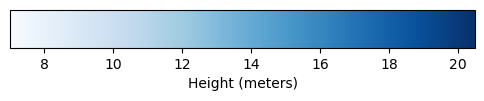

Map(center=[41.90639471585543, 12.48200255418674], controls=(ZoomControl(options=['position', 'zoom_in_text', …

In [10]:
import numpy as np
from pyproj import Transformer
from matplotlib import cm, colors as mcolors
from my_utils.transformations import pose_to_se3

def remove_ground_plane(lidar_points):
    """
    Remove ground plane points based on a height threshold.
    :param lidar_points: Nx3 array of LiDAR points (x, y, z).
    :param ground_threshold: Height threshold for ground removal (in meters).
    :return: Filtered LiDAR points.
    """
    # Filter points with z values above the threshold
    return lidar_points[lidar_points[:, 2] > 7]

def transform_lidar_points(lidar_pc, local_pose, yaw, utm_x0, utm_y0, max_points=1000):
    """
    Transform LiDAR points from local coordinates to global UTM coordinates.
    """
    # # Convert LiDAR points to homogeneous coordinates
    lidar_pc = remove_ground_plane(lidar_pc)
    lidar_xyz_hom = np.hstack([lidar_pc, np.ones((lidar_pc.shape[0], 1))])

    # Apply pose transformation
    pose = pose_to_se3(local_pose).copy()
    pose[:3, 3] = 0  # Zero out translation
    transformed_lidar = (pose @ lidar_xyz_hom.T).T[:, :3]

    # Subsample if too many points
    if transformed_lidar.shape[0] > max_points:
        idxs = np.random.choice(transformed_lidar.shape[0], max_points, replace=False)
        transformed_lidar = transformed_lidar[idxs]

    # Apply yaw rotation
    yaw_heading = np.deg2rad(yaw)
    R_yaw = np.array([[np.cos(yaw_heading), -np.sin(yaw_heading)],
                      [np.sin(yaw_heading), np.cos(yaw_heading)]])
    lidar_positioned = (R_yaw @ transformed_lidar[:, :2].T).T

    # Translate to UTM coordinates
    lidar_utm_frame = lidar_positioned + np.array([utm_x0, utm_y0])

    return lidar_utm_frame, transformed_lidar[:, 2]  # Return UTM points and height values


def convert_to_latlon(utm_points, to_latlon):
    """
    Convert UTM points to latitude and longitude.
    """
    lons, lats = to_latlon.transform(utm_points[:, 0], utm_points[:, 1])
    return lats, lons


def project_lidar_on_map(latlon_traj, lidar_pc, local_pose, to_utm, to_latlon, yaw, max_points=1000):
    """
    Project LiDAR points onto a map using UTM and lat/lon transformations.
    """
    lat0, lon0 = latlon_traj
    utm_x0, utm_y0 = to_utm.transform(lon0, lat0)

    # Transform LiDAR points to UTM coordinates
    utm_points, z_values = transform_lidar_points(lidar_pc, local_pose, yaw, utm_x0, utm_y0, max_points)

    # Convert UTM points to lat/lon
    lats, lons = convert_to_latlon(utm_points, to_latlon)

    # Stack lat/lon and height values
    return np.vstack([lats, lons, z_values])


def plot_lidar_on_map(latlon_traj, heading, lidar_pc, local_pose, to_utm, to_latlon, yaw, max_points=1000,
                      tile_url='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
                      zoom=20, width="600px", height="650px"):
    """
    Plot the trajectory and LiDAR overlay on a map.
    """
    from ipyleaflet import Map, Marker, TileLayer, CircleMarker
    from IPython.display import display

    # Initialize map
    m = Map(center=latlon_traj, zoom=zoom, basemap=TileLayer(url=tile_url), width=width, height=height)
    m.layout.width = width
    m.layout.height = height
    # Add markers
    m.add_layer(Marker(location=latlon_traj))

    # Transform LiDAR points
    lat0, lon0 = latlon_traj
    utm_x0, utm_y0 = to_utm.transform(lon0, lat0)
    utm_points, z_values = transform_lidar_points(lidar_pc, local_pose, yaw, utm_x0, utm_y0, max_points)
    lats, lons = convert_to_latlon(utm_points, to_latlon)
    print("height:",z_values.min(), z_values.max())
    # Generate colors based on height
    color_map = cm.get_cmap('Blues')
    norm = mcolors.Normalize(vmin=z_values.min(), vmax=z_values.max())
    colors = [mcolors.to_hex(color_map(norm(z))) for z in z_values]

    # Add LiDAR points to map
    for lat, lon, color in zip(lats, lons, colors):
        m.add_layer(CircleMarker(location=(lat, lon), radius=1, color=color, fill_opacity=0.1))
    fig, ax = plt.subplots(figsize=(6, 1))
    fig.subplots_adjust(bottom=0.5)

    # Create ScalarMappable for the colorbar
    sm = cm.ScalarMappable(cmap=color_map, norm=norm)
    sm.set_array([])  # Needed for matplotlib < 3.1

    # Add the colorbar
    cbar = plt.colorbar(sm, cax=ax, orientation='horizontal')
    cbar.set_label('Height (meters)')

    plt.show()
    # Display map
    display(m)

# Example usage:
idx = 0
lidar_pc = vbr_scene.get_lidar(idx)
pose = vbr_scene.get_pose(idx)

plot_lidar_on_map(aligned_traj[idx], compass_headings[idx], lidar_pc, pose, to_utm, to_latlon, yaw)

In [11]:
lidar_pc = vbr_scene.get_lidar(idx)


# Find indices where the z value is negative
negative_z_indices = np.where(lidar_pc[:, 2] < 0)[0]

# Print the indices and corresponding points
print(f"Indices with negative height:", {len(negative_z_indices)})
print(f"Points with negative height:\n{lidar_pc[negative_z_indices]}")

Indices with negative height: {55197}
Points with negative height:
[[-1.2476882e+00  6.3727015e-01 -1.3583055e-02]
 [-1.4503562e-01  4.1291520e-01 -3.4943274e-03]
 [-2.0404888e-02  1.3152005e-01 -3.0494147e-04]
 ...
 [-6.2228120e-03 -1.4480402e-03 -4.5458060e-03]
 [-1.7511609e-01 -3.3243272e-02 -1.1808148e-01]
 [-1.7531677e-01 -3.2168157e-02 -1.1808148e-01]]


In [12]:
import ipywidgets as widgets
from ipyleaflet import Map, Marker, TileLayer, CircleMarker
from IPython.display import display
import numpy as np
from matplotlib import cm, colors as mcolors
from my_utils.transformations import pose_to_se3
from ipywidgets import Layout

def update_map(idx):
    """
    Update the map based on the selected index.
    """
    latlon = aligned_traj[idx]
    heading = compass_headings[idx]
    lidar_pc = vbr_scene.get_lidar(idx)
    local_pose = vbr_scene.get_pose(idx)

    # Transform LiDAR points
    lat0, lon0 = latlon
    utm_x0, utm_y0 = to_utm.transform(lon0, lat0)
    utm_points, z_values = transform_lidar_points(lidar_pc, local_pose, yaw, utm_x0, utm_y0, max_points=1000)
    lats, lons = convert_to_latlon(utm_points, to_latlon)

    # Generate colors based on height
    color_map = cm.get_cmap('Blues')
    norm = mcolors.Normalize(vmin=z_values.min(), vmax=z_values.max())
    colors = [mcolors.to_hex(color_map(norm(z))) for z in z_values]

    # Clear previous map layers
    m.layers = [TileLayer(url=tile_url)]

    # Add marker for the current position
    m.add_layer(Marker(location=latlon))

    # Add LiDAR points to map
    for lat, lon, color in zip(lats, lons, colors):
        m.add_layer(CircleMarker(location=(lat, lon), radius=1, color=color, fill_opacity=0.1))


# Initialize map
tile_url = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}'
m = Map(center=aligned_traj[0], zoom=20, basemap=TileLayer(url=tile_url),layout=Layout(width="650px", height="650px"))  # Explicit layout)

# Create slider widget
index_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=len(aligned_traj) - 1,
    step=1,
    description='Index:',
    continuous_update=False
)

# Link slider to map update function
widgets.interactive(update_map, idx=index_slider)

# Display map and slider
display(index_slider)
display(m)

IntSlider(value=0, continuous_update=False, description='Index:', max=42434)

Map(center=[41.90639471585543, 12.48200255418674], controls=(ZoomControl(options=['position', 'zoom_in_text', …